In [1]:
# Load Libs
import csv
import os
import pandas as pd
import numpy as np
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.corpus import stopwords
import nltk
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

In [2]:
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [97]:
# stemming Libs
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

In [98]:
#nltk having predefine data base for stopwords and may models.
#nltk.download()    # Download Repository        

In [99]:
# set working Dir
os.chdir('D:\DATA SCIENCE STUDY METERIAL\Projects\BBC_News_Project')
os.getcwd()

'D:\\DATA SCIENCE STUDY METERIAL\\Projects\\BBC_News_Project'

In [115]:
#load the data
BBC = pd.read_csv('bbc-text.csv')

In [101]:
print(BBC.head())
print(BBC.shape)

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
(2225, 2)


# 1.3 Expletory Data Analysis

In [102]:
BBC_pre=BBC.copy()

In [103]:
# dataset summary
  #BBC.describe()
BBC_pre.groupby('category').describe()

text
category                                                               
business      count                                                 510
              unique                                                503
              top     jobs growth still slow in the us the us create...
              freq                                                    2
entertainment count                                                 386
              unique                                                369
              top     aviator  creator  in oscars snub the man who s...
              freq                                                    2
politics      count                                                 417
              unique                                                403
              top     talks aim to avert pension strike talks aimed ...
              freq                                                    2
sport         count                                                 511
              unique                                                504
              top     edwards tips idowu for euro gold world outdoor...
              freq                                                    2
tech          count                                                 401
              unique                                                347
              top     broadband in the uk growing fast high-speed ne...
              freq                                                    2

In [104]:
# calculate the length of the strings in each document. 
BBC_pre['length']=BBC_pre['text'].apply(len)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000162CAF28>,
      dtype=object)

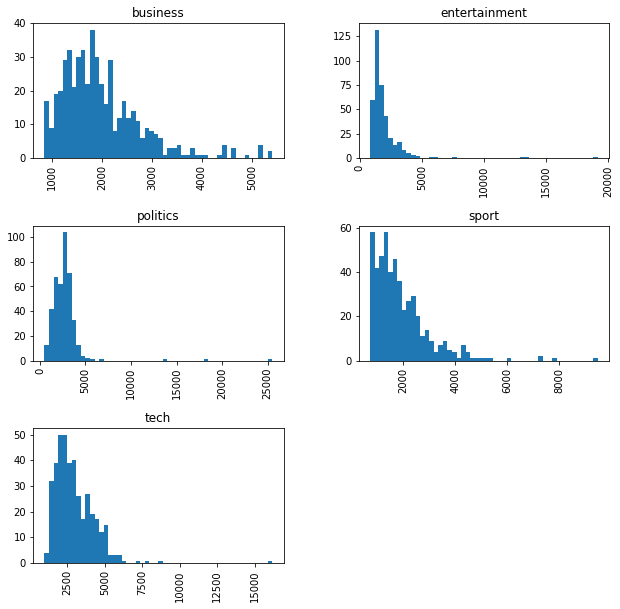

In [105]:
BBC_pre.hist(column='length', by='category', bins=50,figsize=(10,10))

# Text Preprocessing

In [106]:
# stop words
stop = set(stopwords.words("english"))    # Pre define stopwords in nltk lib

# Punctuation marks
exclude = set(string.punctuation)         # Pre define punctuation marks in inbuilt lib


In [116]:
# Text pre processing
def clean(doc):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation.
    2. Remove all intigers.
    3. Remove all stopwords.
    4. Returns a list of the cleaned text
    """
    punc_free = " ".join([ch for ch in doc.lower().split() if ch not in exclude])
    num_free = "".join([i for i in punc_free if not i.isdigit()])
    stop_free = " ".join([i for i in num_free.lower().split() if i not in stop])
    
    return stop_free

def clean_token(doc):
   
    punc_free = " ".join([ch for ch in doc.lower().split() if ch not in exclude])
    num_free = "".join([i for i in punc_free if not i.isdigit()])
    stop_free = [i for i in num_free.lower().split() if i not in stop]
   
    return stop_free

In [117]:
# apply pre processing function on the text data.
BBC['text'] = BBC['text'].apply(clean)


In [119]:
BBC.to_csv("preprocessed_data.csv",index=False)

In [118]:
BBC.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


## vectorization

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

In [120]:
# create beg of words
bow_transformer = CountVectorizer(analyzer=clean_token).fit(BBC['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

39572


In [121]:
BBC_bow = bow_transformer.transform(BBC['text'])

In [122]:
print('Shape of Sparse Matrix: ',  BBC_bow.shape)
print('Amount of Non-Zero occurences: ', BBC_bow.nnz)

Shape of Sparse Matrix:  (2225, 39572)
Amount of Non-Zero occurences:  356362


In [123]:
sparsity = (100.0 * BBC_bow.nnz / (BBC_bow.shape[0] * BBC_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

sparsity: 0.4047374320964659



## tf-idf transformation

In [124]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(BBC_bow)
print(tfidf_transformer)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)


In [125]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['v']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['away']])

5.181601007219329
3.269882222912295


In [126]:
BBC_tfidf = tfidf_transformer.transform(BBC_bow)
print(BBC_tfidf.shape)

(2225, 39572)


# model devlopment

In [133]:
# nAIVE BAYES
from sklearn.naive_bayes import MultinomialNB

In [177]:
X = BBC['text']
y = BBC['category']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=151)
print("Documents in training set are :",len(X_train))
print("Documents in test set are :",len(X_test))
print("Total documents in courpus are :",(len(X_train) + len(X_test)))

Documents in training set are : 1557
Documents in test set are : 668
Total documents in courpus are : 2225


In [163]:
# create pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [164]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [165]:
predictions = pipeline.predict(X_test)

In [166]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[140   0   1   0   1]
 [  4 110   5   0   0]
 [  1   0 119   0   1]
 [  0   0   0 157   0]
 [  1   0   1   3 124]]
               precision    recall  f1-score   support

     business       0.96      0.99      0.97       142
entertainment       1.00      0.92      0.96       119
     politics       0.94      0.98      0.96       121
        sport       0.98      1.00      0.99       157
         tech       0.98      0.96      0.97       129

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668



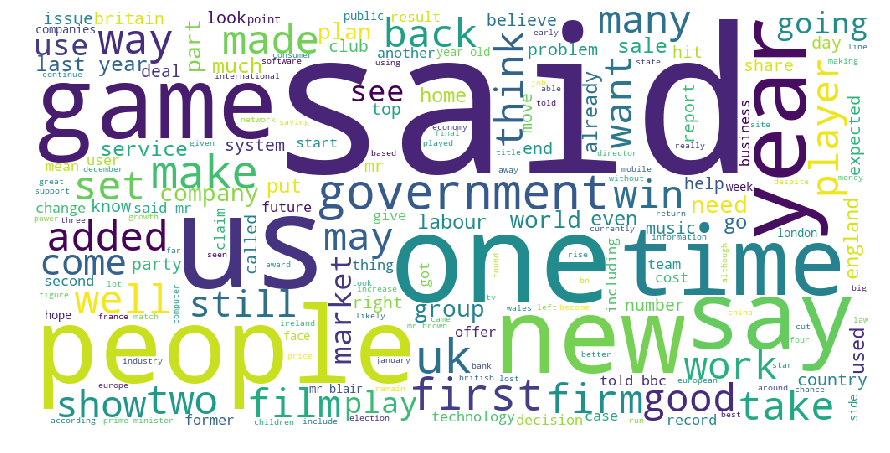

In [167]:
#Plot wordcloud
wordcloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(
                        ''.join(BBC['text']))

plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()